In [ ]:
!pip install highway_env
!pip install import-ipynb

In [2]:
import os 
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/HW5')
# !rm -rf /content/drive/MyDrive/HW5/Merge/
# !rm -rf /content/drive/MyDrive/HW5/Highway/
# !rm -rf /content/drive/MyDrive/HW5/Highway-MW/
# !rm -rf /content/drive/MyDrive/HW5/CNN/
# !mkdir /content/drive/MyDrive/HW5/Merge
# !mkdir /content/drive/MyDrive/HW5/Merge/Weights
# !mkdir /content/drive/MyDrive/HW5/Merge/Render
# !mkdir /content/drive/MyDrive/HW5/Highway
# !mkdir /content/drive/MyDrive/HW5/Highway/Weights
# !mkdir /content/drive/MyDrive/HW5/Highway/Render
# !mkdir /content/drive/MyDrive/HW5/Highway-MW
# !mkdir /content/drive/MyDrive/HW5/Highway-MW/Weights
# !mkdir /content/drive/MyDrive/HW5/Highway-MW/Render
# !mkdir /content/drive/MyDrive/HW5/CNN
# !mkdir /content/drive/MyDrive/HW5/CNN/Weights
# !mkdir /content/drive/MyDrive/HW5/CNN/Render

Mounted at /content/drive/


In [ ]:
import gym
import math
import random
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter   
import highway_env
import warnings
import math
import pygame
from scipy.stats import t


highway_env.register_highway_envs()
warnings.filterwarnings("ignore")
highway_env.register_highway_envs()
os.environ['SDL_VIDEODRIVER']='dummy'
pygame.display.set_mode((640,480))
os.environ['SDL_VIDEODRIVER']='x11'
pygame.display.set_mode((640,480))
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

is_ipython = 'inline' in matplotlib.get_backend()
from IPython import display

# **Q2 (Merge)** 
## **Initialization**

In [ ]:
BATCH_SIZE = 32
LR = 0.0001                
EPSILON = 0.1               
SETTING_TIMES = 500         
GAMMA = 0.8               
TARGET_REPLACE_ITER = 1000  
MEMORY_CAPACITY = 2000
N_ACTIONS = 5 
N_STATES = 25 
N_LAYERS = [256, 256]
REPEAT=5
EPISODE=1000
TEST_EPISODE=30
learning_rate = 0.0001
GAMMA = 0.8
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 50

## **Record Video**
This function is used to captured all screen from `env.render()` and merge them as a `.gif` file.

In [ ]:
def Record_Video(frames,i_episode, path='/content/drive/MyDrive/HW5/Merge/Render/', filename='Merge.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('on')

    def animate(i):
        patch.set_data(frames[i])
    writer = animation.PillowWriter(fps=480,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=200)
    anim.save(path +str(i_episode)+filename, writer=writer)

## **Network Implementation**
Our model will be a convolution neural network that takes in 25 array as state,which represend all vehicles and their features. in our model we use 3 linear layer.


In [ ]:
class DQN_Net(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.fc1 = nn.Linear(N_STATES, N_LAYERS[0])
        self.fc1.weight.data.normal_(0, 0.1) # initialization

        self.fc2 = nn.Linear(N_LAYERS[0], N_LAYERS[1])
        self.fc2.weight.data.normal_(0, 0.1) # initialization

        self.out = nn.Linear(N_LAYERS[1], N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1) # initialization

        self.N_ACTIONS = N_ACTIONS
        self.N_STATES = N_STATES

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

## **DQN Implementation**
in this part we have two network, evaluation network and target network. Evaluation network is update in each step and Target Network is update each 1000 step.

Our loss function is MSE and compute the difference between 

In [ ]:
class DQN(object):
    def __init__(self, is_train=True):
      
        self.IS_TRAIN = is_train
        self.eval_net, self.target_net = DQN_Net().to(device), DQN_Net().to(device)
        self.learn_step_counter = 0     # for target updating
        self.memory_counter = 0         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, self.eval_net.N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()
        self.writer = SummaryWriter('./log') if self.IS_TRAIN else None

        self.BATCH_SIZE = BATCH_SIZE
        self.LR = LR
        self.EPSILON = EPSILON if self.IS_TRAIN else 1.0
        self.SETTING_TIMES = SETTING_TIMES
        self.GAMMA = GAMMA
        self.TARGET_REPLACE_ITER = TARGET_REPLACE_ITER
        self.MEMORY_CAPACITY = MEMORY_CAPACITY
        self.N_STATES = self.eval_net.N_STATES

    def choose_action(self, x):

        x = torch.unsqueeze(torch.FloatTensor(x), 0).to(device) # add 1 dimension to input state x

        if np.random.uniform() < self.EPSILON: # greedy
            action_value = self.eval_net.forward(x).cpu()
            action_index = torch.max(action_value, 1)[1].data.numpy()[0] 
            action_max_value = torch.max(action_value, 1)[0].data.numpy()[0]
        else:
            action_index = np.random.randint(0, self.eval_net.N_ACTIONS)
            action_max_value = 0
        return action_index, action_max_value

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1
    
    def learn(self):
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :self.eval_net.N_STATES]).to(device)
        b_a = torch.LongTensor(b_memory[:, self.eval_net.N_STATES:self.eval_net.N_STATES+1].astype(int)).to(device)
        b_r = torch.FloatTensor(b_memory[:, self.eval_net.N_STATES+1:self.eval_net.N_STATES+2]).to(device)
        b_s_ = torch.FloatTensor(b_memory[:, -self.eval_net.N_STATES:]).to(device)

        q_eval = self.eval_net(b_s).gather(1, b_a)  
        q_next = self.target_net(b_s_).detach()     
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if (self.IS_TRAIN):
            if (self.learn_step_counter % 100 == 0):
                self.writer.add_scalar('Loss', loss.cpu(), self.learn_step_counter)

    def save(self,path):
        torch.save(self.eval_net.state_dict(), path)
    def load(self,path):
        self.eval_net.load_state_dict(torch.load(path))
        self.target_net.load_state_dict(torch.load(path))

## **Train Agent**

In [ ]:
def train_model(environment,REPEAT=REPEAT,EPISODE=EPISODE,path="Merge",load_data=False,load_path=""):
  Episode_Reward=np.zeros(shape=(REPEAT,EPISODE))
  env = gym.make(environment)
  dqn = DQN(is_train=True)
  if load_data:
    dqn.load(load_path)
  for r in range(REPEAT):
    if __name__ == '__main__':
      print('--------------\nCollecting experience...\n--------------')
      best_reward = 0
      for i_episode in range(EPISODE):
          if i_episode <= dqn.SETTING_TIMES:
              dqn.EPSILON = 0.1 + i_episode / dqn.SETTING_TIMES * (0.9 - 0.1)
          s = env.reset()
          s = np.squeeze(np.reshape(list(s)[0],(1,dqn.N_STATES)))
          # indirect params
          total_reward = 0
          total_action_value = 0
          action_counter = 1 
          reward_counter = 0
          bool_learning = False
          while True:
              action_index, action_value = dqn.choose_action(s)
              action = action_index
              s_, reward, done,_, info = env.step(action)
              s = np.squeeze(np.reshape(s,(1,dqn.N_STATES)))
              s_ = np.squeeze(np.reshape(s_,(1,dqn.N_STATES)))
              dqn.store_transition(s, action_index, reward, s_)
              total_reward += reward
              reward_counter += 1   
              if dqn.memory_counter > dqn.MEMORY_CAPACITY:
                  bool_learning = True
                  dqn.learn()
              if done:
                  if best_reward <= total_reward and bool_learning:
                      best_reward = total_reward
                      dqn.save("/content/drive/MyDrive/HW5/"+path+"/Weights/reward"+str(round(best_reward))+"weights.pt")
              
                  print('Repeat:',r,'Episode: ', i_episode, ' |', 'Total Reward: ', round(total_reward, 2), ' |', 'Best_r: ', round(best_reward, 2))
                  break
              else:
                  s = s_              
          Episode_Reward[r][i_episode]=total_reward
  return Episode_Reward

## **Test Agent**

In [ ]:
def test_agent(environment,load_path,Epsiode,save_path,file_name):
  env = gym.make(environment)
  dqn = DQN(is_train=False)
  dqn.load(load_path)
  print('--------------\nLoading experience...\n--------------')
  for i_episode in range(Epsiode):
      s = env.reset()
      s = np.squeeze(np.reshape(list(s)[0],(1,dqn.N_STATES)))
      step=0
      total_reward = 0
      frames = []
      while True:
          frames.append(env.render(mode="rgb_array"))
          action_index, action_value = dqn.choose_action(s)
          action = action_index
          s_, reward, done,truncate, info = env.step(action)
          # slice s and s_
          s = np.squeeze(np.reshape(s,(1,dqn.N_STATES)))
          s_ = np.squeeze(np.reshape(s_,(1,dqn.N_STATES)))
          total_reward += reward
          s = s_  
          if done :
              print( f'Episode: ', i_episode, '  |', 'Total Reward:', round(total_reward,2) )
              Record_Video(frames,i_episode,path=save_path,filename=file_name)
              break
          step+=1


## **Execution Train**

In [ ]:
Episode_Reward_Merge=train_model("merge-v0",REPEAT=5,EPISODE=1000)

Streaming output truncated to the last 5000 lines.
Repeat: 0 Episode:  12  | Total Reward:  10.33  | Best_r:  0
Repeat: 0 Episode:  13  | Total Reward:  11.03  | Best_r:  0
Repeat: 0 Episode:  14  | Total Reward:  12.5  | Best_r:  0
Repeat: 0 Episode:  15  | Total Reward:  12.69  | Best_r:  0
Repeat: 0 Episode:  16  | Total Reward:  3.94  | Best_r:  0
Repeat: 0 Episode:  17  | Total Reward:  11.75  | Best_r:  0
Repeat: 0 Episode:  18  | Total Reward:  10.55  | Best_r:  0
Repeat: 0 Episode:  19  | Total Reward:  10.61  | Best_r:  0
Repeat: 0 Episode:  20  | Total Reward:  11.75  | Best_r:  0
Repeat: 0 Episode:  21  | Total Reward:  10.72  | Best_r:  0
Repeat: 0 Episode:  22  | Total Reward:  11.94  | Best_r:  0
Repeat: 0 Episode:  23  | Total Reward:  12.42  | Best_r:  0
Repeat: 0 Episode:  24  | Total Reward:  10.58  | Best_r:  0
Repeat: 0 Episode:  25  | Total Reward:  11.97  | Best_r:  0
Repeat: 0 Episode:  26  | Total Reward:  12.22  | Best_r:  0
Repeat: 0 Episode:  27  | Total Rewa

## **Plot Diagram - Average Reward**




In [ ]:
Episode_Reward_mean=Episode_Reward_Merge.mean(axis=0)
df = pd.DataFrame(Episode_Reward_mean)
rolling=df.rolling(30).mean()
m=rolling.mean()
rolling.fillna(value=m, inplace=True)
rolling=rolling.to_numpy()
rolling=np.squeeze(rolling)
alpha=0.05
confidence_interval = np.abs(t.ppf(alpha/2,len(rolling)-1)) * np.std(rolling) / np.sqrt(len(rolling))

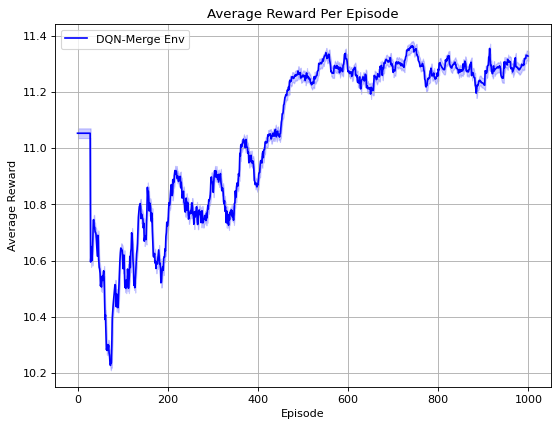

In [ ]:
plt.figure(figsize=(8,6),dpi=80)
plt.plot(rolling,c='b',label='DQN-Merge Env')
plt.fill_between(np.arange(1,EPISODE+1,1), (rolling-confidence_interval),
                 (rolling+confidence_interval), color='b', alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Average Reward Per Episode")
plt.legend()
plt.grid()
plt.show()

## **Test Agent and Record Video of Rendering**

--------------
Loading experience...
--------------
Episode:  0   | Total Reward: 11.28
Episode:  1   | Total Reward: 11.28
Episode:  2   | Total Reward: 11.28
Episode:  3   | Total Reward: 11.28
Episode:  4   | Total Reward: 11.28
Episode:  5   | Total Reward: 11.28
Episode:  6   | Total Reward: 11.28
Episode:  7   | Total Reward: 11.28
Episode:  8   | Total Reward: 11.28
Episode:  9   | Total Reward: 11.28
Episode:  10   | Total Reward: 11.28
Episode:  11   | Total Reward: 11.28
Episode:  12   | Total Reward: 11.28
Episode:  13   | Total Reward: 11.28
Episode:  14   | Total Reward: 11.28
Episode:  15   | Total Reward: 11.28
Episode:  16   | Total Reward: 11.28
Episode:  17   | Total Reward: 11.28
Episode:  18   | Total Reward: 11.28
Episode:  19   | Total Reward: 11.28
Episode:  20   | Total Reward: 11.28
Episode:  21   | Total Reward: 11.28
Episode:  22   | Total Reward: 11.28
Episode:  23   | Total Reward: 11.28
Episode:  24   | Total Reward: 11.28
Episode:  25   | Total Reward: 11

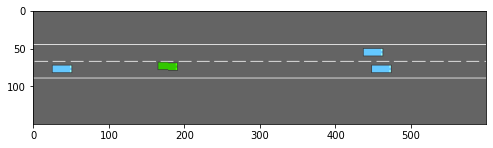

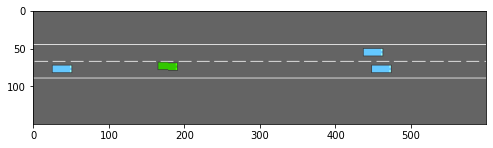

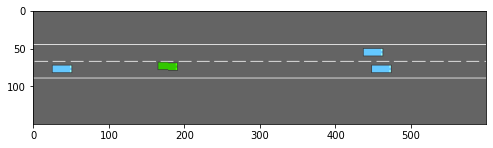

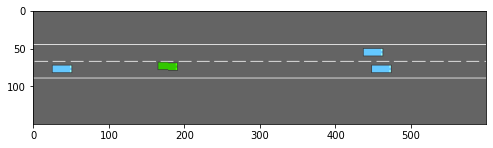

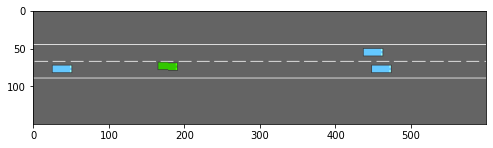

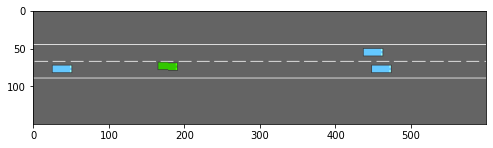

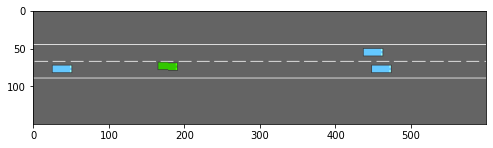

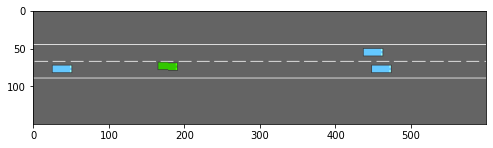

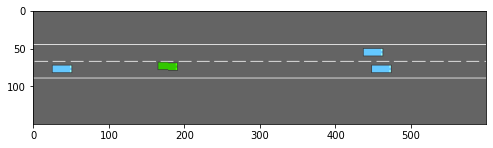

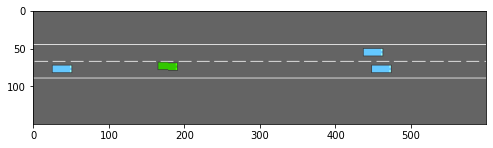

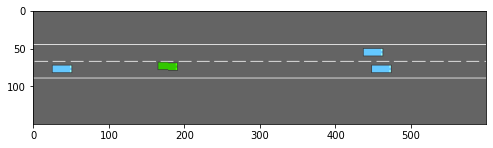

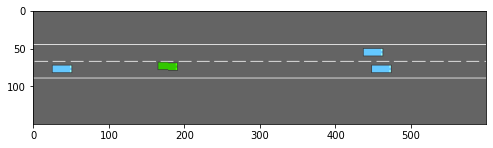

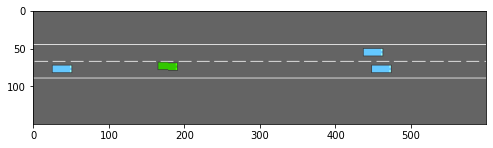

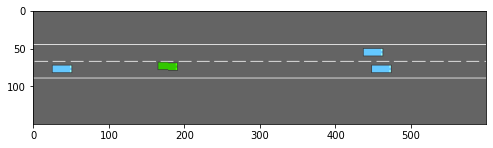

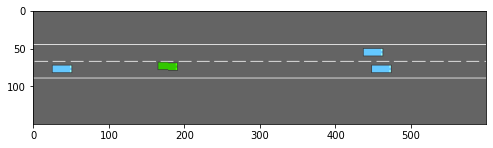

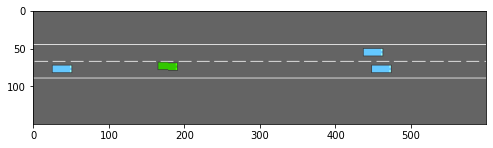

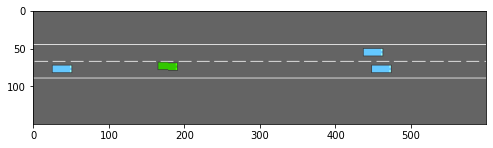

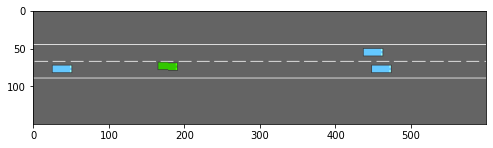

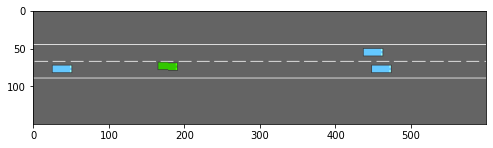

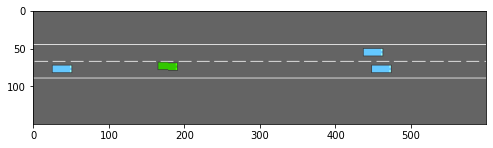

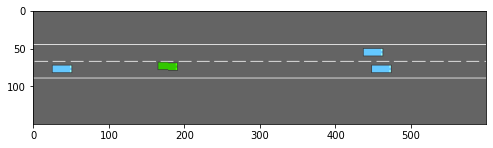

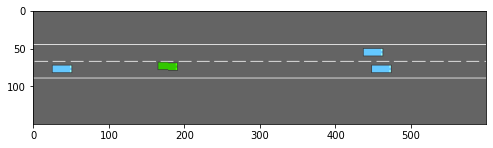

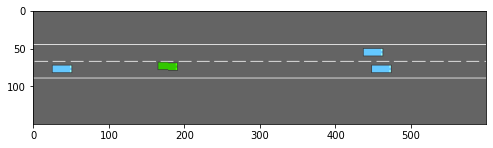

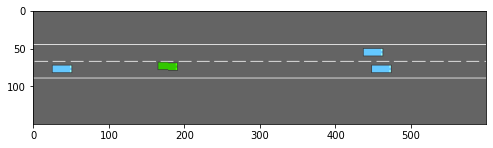

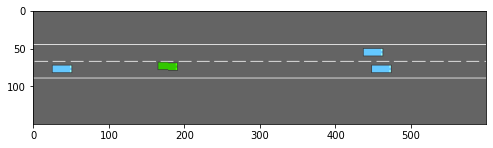

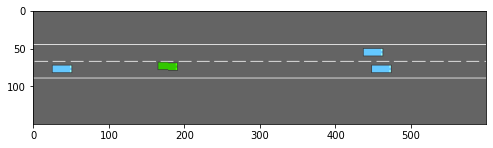

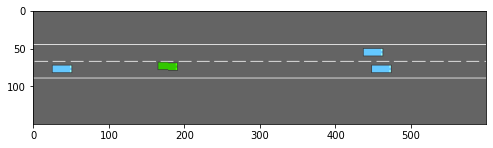

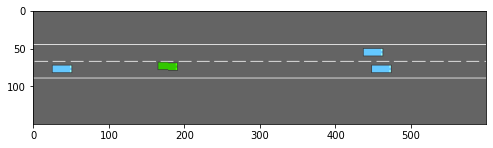

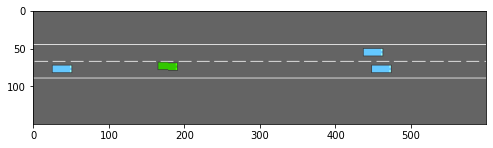

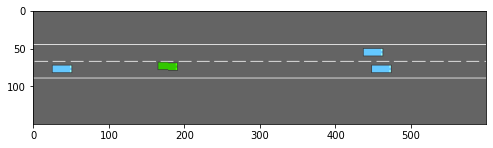

In [ ]:
test_agent("merge-v0","/content/drive/MyDrive/HW5/Merge/Weights/reward14weights.pt",Epsiode=TEST_EPISODE,save_path="/content/drive/MyDrive/HW5/Merge/Render/",file_name="Merge.gif")

# **Q3 - Transer Learning (Highway-Fast)**
## **Train Agent-Random Weights**

In [ ]:
Episode_Reward_Highway=train_model("highway-fast-v0",REPEAT=5,EPISODE=1000,path="Highway")

Streaming output truncated to the last 5000 lines.
Repeat: 0 Episode:  12  | Total Reward:  17.77  | Best_r:  0
Repeat: 0 Episode:  13  | Total Reward:  9.39  | Best_r:  0
Repeat: 0 Episode:  14  | Total Reward:  6.53  | Best_r:  0
Repeat: 0 Episode:  15  | Total Reward:  9.73  | Best_r:  0
Repeat: 0 Episode:  16  | Total Reward:  6.94  | Best_r:  0
Repeat: 0 Episode:  17  | Total Reward:  3.85  | Best_r:  0
Repeat: 0 Episode:  18  | Total Reward:  5.06  | Best_r:  0
Repeat: 0 Episode:  19  | Total Reward:  20.21  | Best_r:  0
Repeat: 0 Episode:  20  | Total Reward:  9.18  | Best_r:  0
Repeat: 0 Episode:  21  | Total Reward:  2.5  | Best_r:  0
Repeat: 0 Episode:  22  | Total Reward:  1.8  | Best_r:  0
Repeat: 0 Episode:  23  | Total Reward:  4.07  | Best_r:  0
Repeat: 0 Episode:  24  | Total Reward:  13.57  | Best_r:  0
Repeat: 0 Episode:  25  | Total Reward:  20.88  | Best_r:  0
Repeat: 0 Episode:  26  | Total Reward:  1.72  | Best_r:  0
Repeat: 0 Episode:  27  | Total Reward:  14.62 

## **Plot Diagram -  Average Reward**

In [ ]:
Episode_Reward_mean=Episode_Reward_Highway.mean(axis=0)
df = pd.DataFrame(Episode_Reward_mean)
rolling=df.rolling(30).mean()
m=rolling.mean()
rolling.fillna(value=m, inplace=True)
rolling=rolling.to_numpy()
rolling=np.squeeze(rolling)
alpha=0.05
confidence_interval = np.abs(t.ppf(alpha/2,len(rolling)-1)) * np.std(rolling) / np.sqrt(len(rolling))

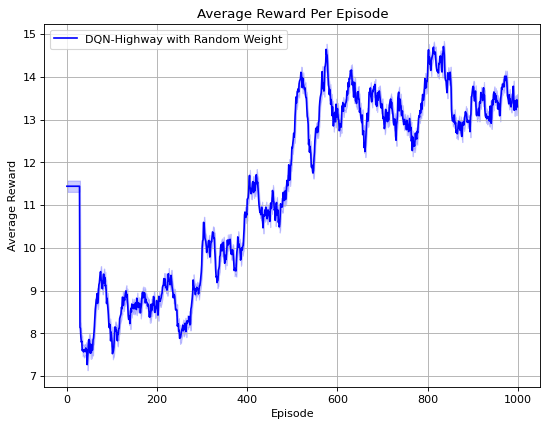

In [ ]:
plt.figure(figsize=(8,6),dpi=80)
plt.plot(rolling,c='b',label='DQN-Highway with Random Weight')
plt.fill_between(np.arange(1,EPISODE+1,1), (rolling-confidence_interval),
                 (rolling+confidence_interval), color='b', alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Average Reward Per Episode")
plt.legend()
plt.grid()
plt.show()

--------------
Loading experience...
--------------
Episode:  0   | Total Reward: 28.71
Episode:  1   | Total Reward: 20.64
Episode:  2   | Total Reward: 28.91
Episode:  3   | Total Reward: 29.21
Episode:  4   | Total Reward: 14.21
Episode:  5   | Total Reward: 5.08
Episode:  6   | Total Reward: 10.68
Episode:  7   | Total Reward: 23.51
Episode:  8   | Total Reward: 3.01
Episode:  9   | Total Reward: 29.28
Episode:  10   | Total Reward: 28.81
Episode:  11   | Total Reward: 28.34
Episode:  12   | Total Reward: 14.71
Episode:  13   | Total Reward: 28.68
Episode:  14   | Total Reward: 16.85
Episode:  15   | Total Reward: 29.11
Episode:  16   | Total Reward: 12.48
Episode:  17   | Total Reward: 10.52
Episode:  18   | Total Reward: 13.75
Episode:  19   | Total Reward: 7.48
Episode:  20   | Total Reward: 4.68
Episode:  21   | Total Reward: 12.12
Episode:  22   | Total Reward: 29.14
Episode:  23   | Total Reward: 12.25
Episode:  24   | Total Reward: 10.01
Episode:  25   | Total Reward: 8.65
E

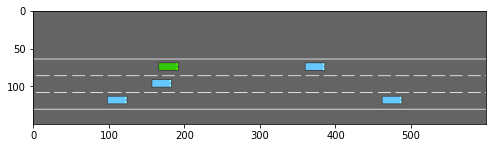

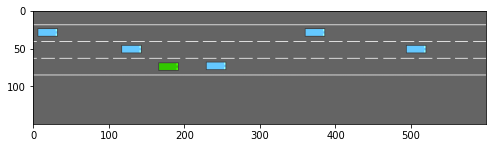

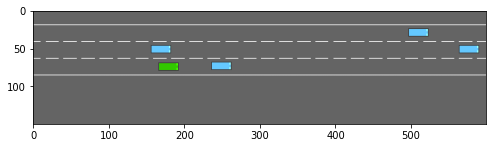

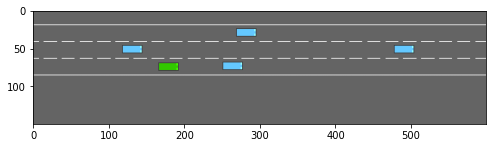

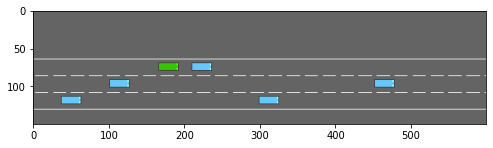

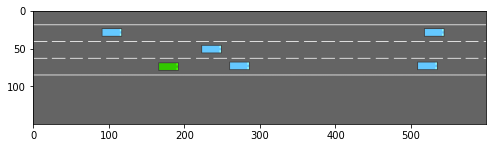

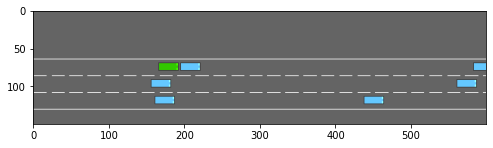

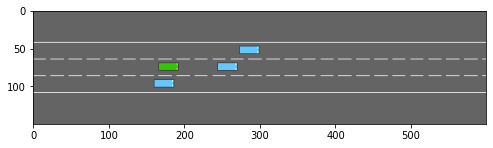

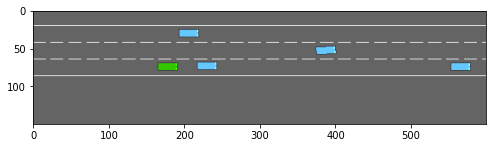

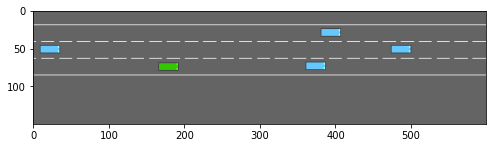

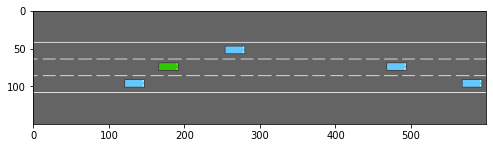

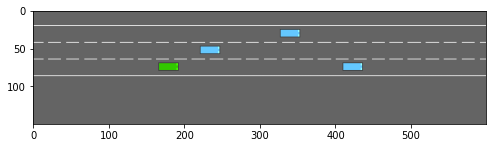

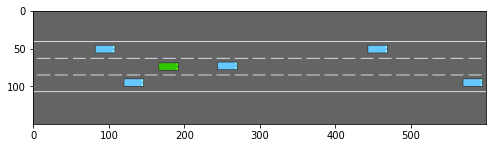

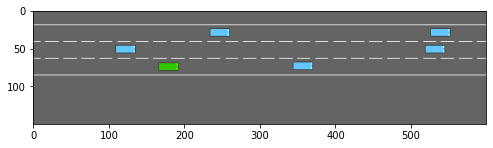

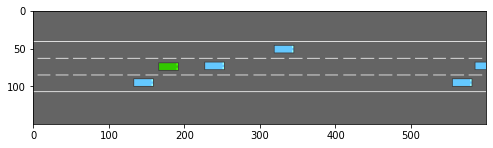

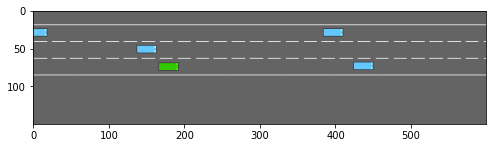

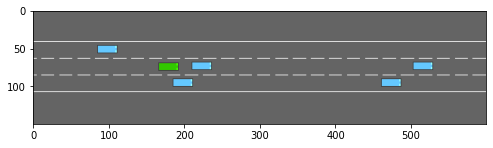

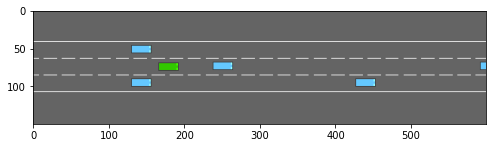

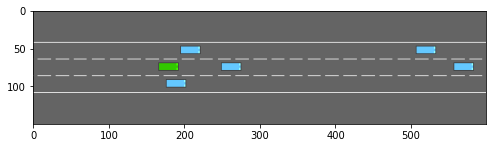

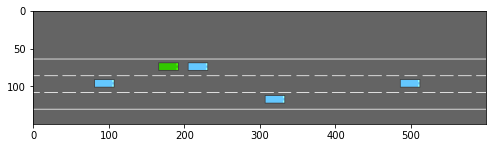

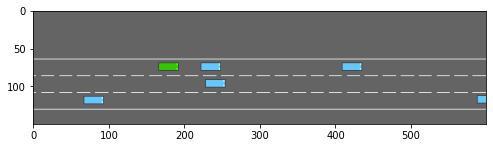

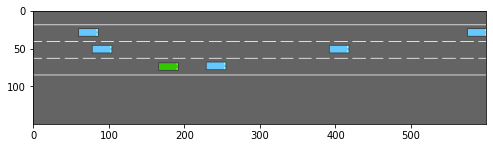

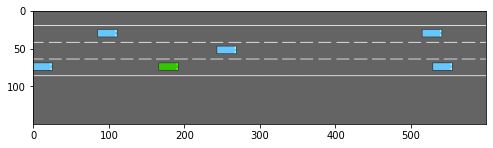

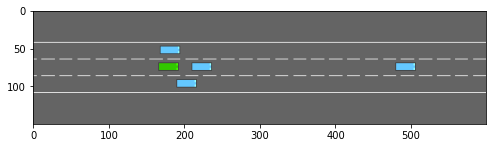

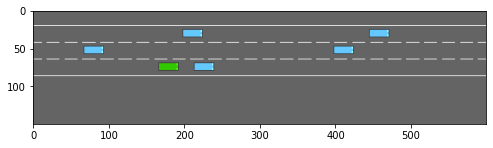

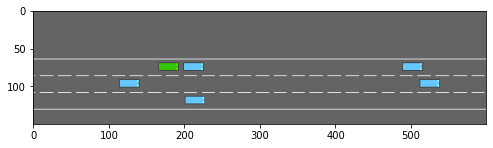

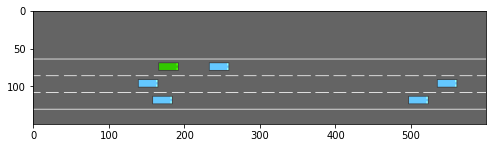

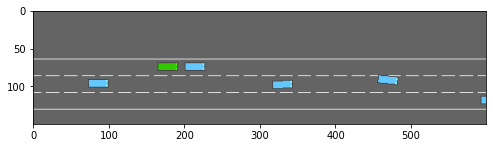

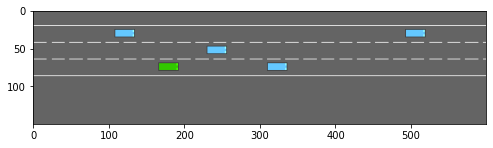

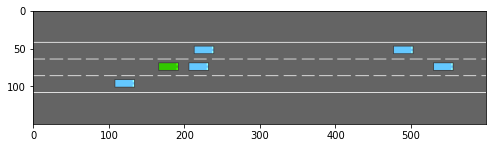

In [ ]:
test_agent("highway-fast-v0","/content/drive/MyDrive/HW5/Highway/Weights/reward30weights.pt",save_path='/content/drive/MyDrive/HW5/Highway/Render/',file_name='Highway.gif',Epsiode=TEST_EPISODE)

## **Train Agent-Merge Weights**


In [ ]:
Episode_Reward_Highway_mergew=train_model("highway-fast-v0",REPEAT=5,EPISODE=1000,path="Highway-MW",load_data=True,load_path="/content/drive/MyDrive/HW5/Merge/Weights/reward14weights.pt")

Streaming output truncated to the last 5000 lines.
Repeat: 0 Episode:  12  | Total Reward:  5.75  | Best_r:  0
Repeat: 0 Episode:  13  | Total Reward:  2.99  | Best_r:  0
Repeat: 0 Episode:  14  | Total Reward:  6.43  | Best_r:  0
Repeat: 0 Episode:  15  | Total Reward:  22.19  | Best_r:  0
Repeat: 0 Episode:  16  | Total Reward:  2.65  | Best_r:  0
Repeat: 0 Episode:  17  | Total Reward:  4.61  | Best_r:  0
Repeat: 0 Episode:  18  | Total Reward:  1.8  | Best_r:  0
Repeat: 0 Episode:  19  | Total Reward:  19.84  | Best_r:  0
Repeat: 0 Episode:  20  | Total Reward:  9.27  | Best_r:  0
Repeat: 0 Episode:  21  | Total Reward:  23.18  | Best_r:  0
Repeat: 0 Episode:  22  | Total Reward:  16.33  | Best_r:  0
Repeat: 0 Episode:  23  | Total Reward:  9.11  | Best_r:  0
Repeat: 0 Episode:  24  | Total Reward:  4.87  | Best_r:  0
Repeat: 0 Episode:  25  | Total Reward:  13.47  | Best_r:  0
Repeat: 0 Episode:  26  | Total Reward:  7.47  | Best_r:  0
Repeat: 0 Episode:  27  | Total Reward:  4.71

## **Plot Diagram -  Average Reward**

In [ ]:
Episode_Reward_mean=Episode_Reward_Highway_mergew.mean(axis=0)
df = pd.DataFrame(Episode_Reward_mean)
rolling=df.rolling(30).mean()
m=rolling.mean()
rolling.fillna(value=m, inplace=True)
rolling=rolling.to_numpy()
rolling=np.squeeze(rolling)
alpha=0.05
confidence_interval = np.abs(t.ppf(alpha/2,len(rolling)-1)) * np.std(rolling) / np.sqrt(len(rolling))

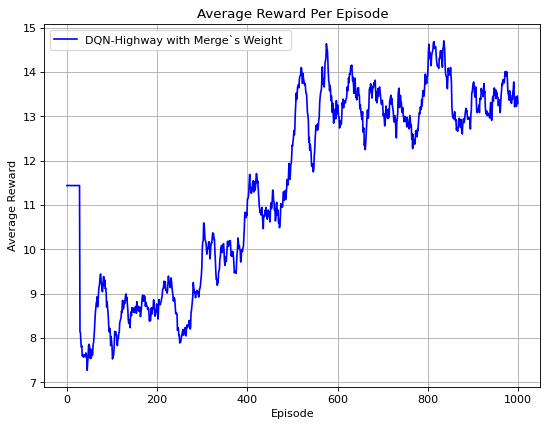

In [ ]:
plt.figure(figsize=(8,6),dpi=80)
plt.plot(rolling,c='b',label='DQN-Highway with Merge`s Weight ')
# plt.fill_between(np.arange(1,EPISODE+1,1), (rolling-confidence_interval),
#                  (rolling+confidence_interval), color='b', alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Average Reward Per Episode")
plt.legend()
plt.grid()
plt.show()

--------------
Loading experience...
--------------
Episode:  0   | Total Reward: 4.65
Episode:  1   | Total Reward: 3.91
Episode:  2   | Total Reward: 6.15
Episode:  3   | Total Reward: 29.18
Episode:  4   | Total Reward: 7.91
Episode:  5   | Total Reward: 18.18
Episode:  6   | Total Reward: 19.05
Episode:  7   | Total Reward: 9.01
Episode:  8   | Total Reward: 12.78
Episode:  9   | Total Reward: 24.44
Episode:  10   | Total Reward: 6.95
Episode:  11   | Total Reward: 22.58
Episode:  12   | Total Reward: 15.35
Episode:  13   | Total Reward: 7.88
Episode:  14   | Total Reward: 27.71
Episode:  15   | Total Reward: 5.15
Episode:  16   | Total Reward: 7.65
Episode:  17   | Total Reward: 17.61
Episode:  18   | Total Reward: 15.23
Episode:  19   | Total Reward: 5.21
Episode:  20   | Total Reward: 29.38
Episode:  21   | Total Reward: 17.48
Episode:  22   | Total Reward: 9.61
Episode:  23   | Total Reward: 7.78
Episode:  24   | Total Reward: 17.05
Episode:  25   | Total Reward: 29.31
Episode:

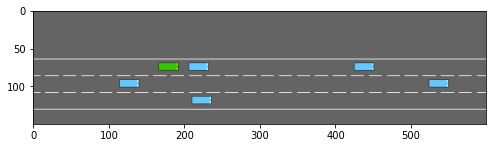

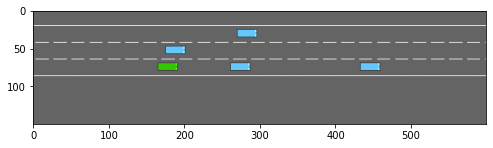

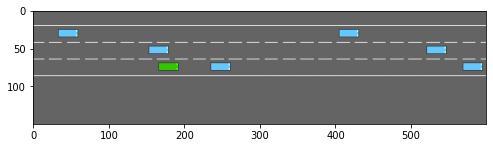

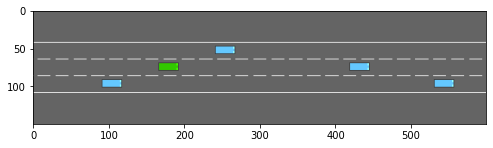

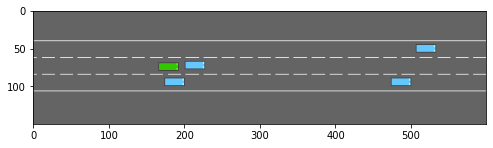

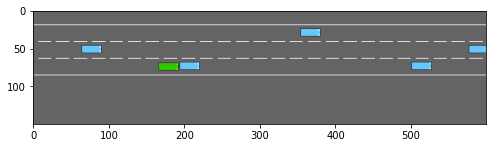

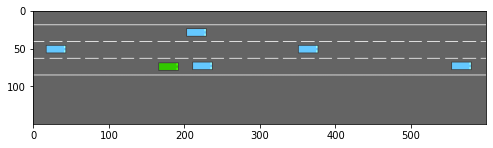

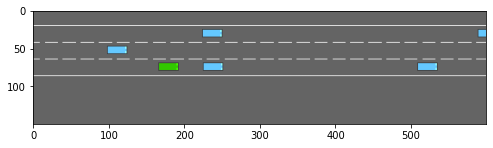

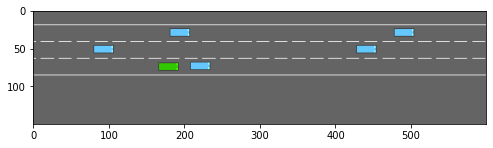

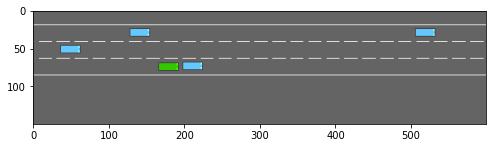

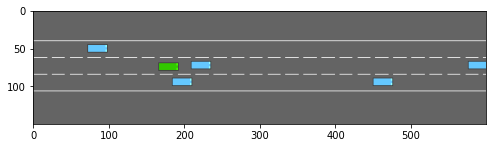

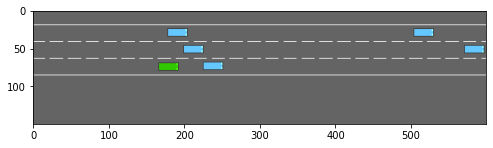

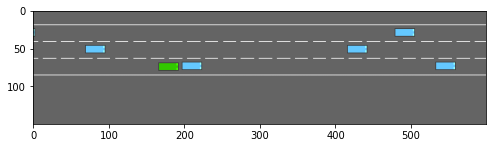

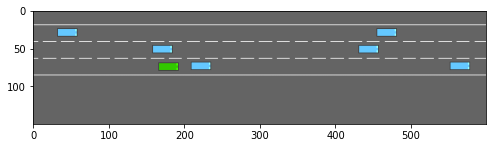

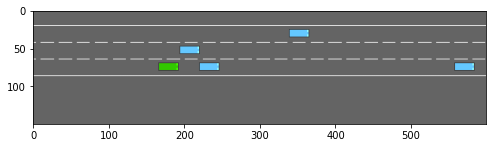

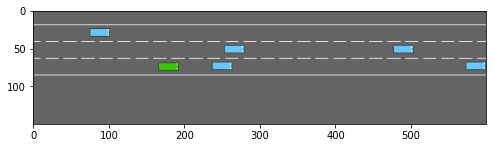

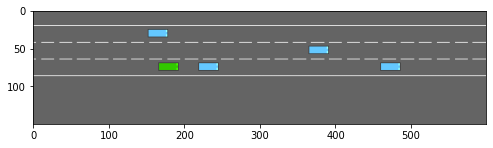

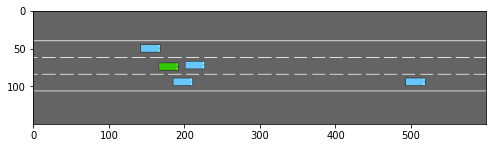

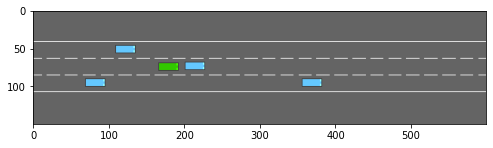

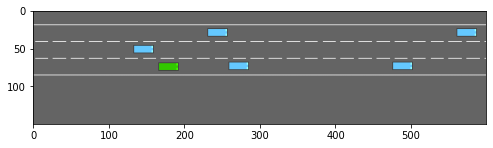

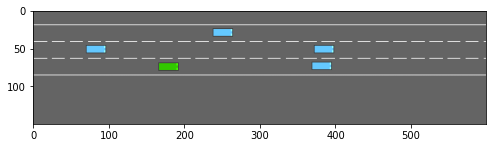

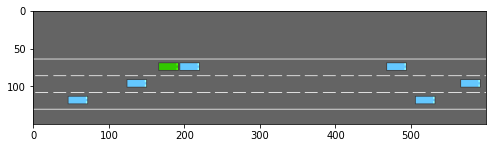

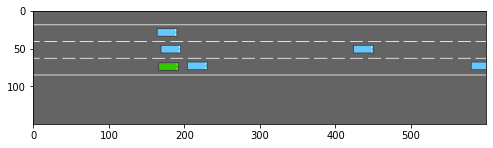

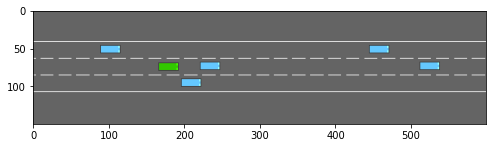

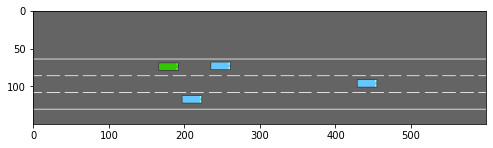

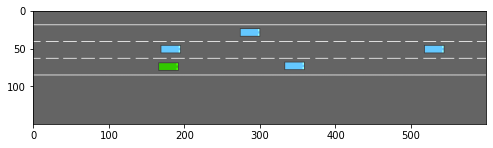

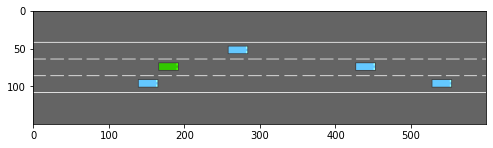

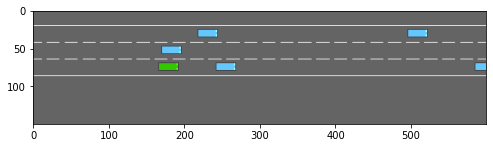

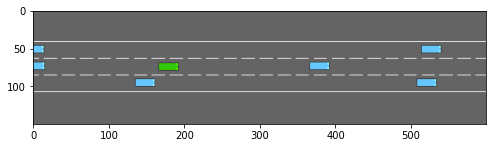

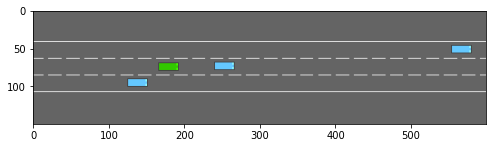

In [ ]:
test_agent("highway-fast-v0","/content/drive/MyDrive/HW5/Highway-MW/Weights/reward23weights.pt",save_path='/content/drive/MyDrive/HW5/Highway-MW/Render/',file_name='Highway-MW.gif',Epsiode=TEST_EPISODE)

# **Q4 (CNN)**

## **Function to Extract Image**
This function extracts the image from the environment, converts it to numbers as floats, rescales it, and finally converts it to torch tensors.

In [ ]:
def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0)

## **Function for Storing Transition**
We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we’re going to need two classses:


*   **Transition** - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.
*   **ReplayMemory** - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.
(Reference:https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)







In [ ]:
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
         #Save a transition
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## **CNN Network Implementation**
Our model will be a convolutional neural network that takes in the difference between the current and previous screen patches.

---
Parameters:
*   Kernel Size is the size of window to move
*   Stride means the quantity of shift of kernel



In [ ]:
class DQN_CNN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
    #Activator Function
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## **Initialization**


In [ ]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
env=gym.make("merge-v0")
resize = T.Compose([T.ToPILImage(),
                    T.Resize(100, interpolation=T.InterpolationMode.BICUBIC),
                    T.ToTensor()])
env.reset()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n
policy_net = DQN_CNN(screen_height, screen_width, n_actions).to(device)
target_net = DQN_CNN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = Adam(policy_net.parameters(),lr = learning_rate)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

## **Action Selection**
Select Action using Epsilon Decaying Greedy 

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

## **Optimize Model**
Here, you can find an optimize_model function that performs a single step of the optimization. It first samples a batch, concatenates all the tensors into a single one, computes State Action Value and combines them into our loss.
Policy Network is used to update every episode and Target Net is used to add stability.

For loss function, I used the Huber loss is a loss function used in robust regression, that is less sensitive to outliers in data than the squared error loss. Our loss function compute the difference between output policy network as state action value and output of target network as next state action value.

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## **Train Model**
in this part, we use `train_model_cnn` function to train the model. it is also save our model weight per best reward and update target network in each 50 episode.

In [ ]:
def train_model_cnn(REPEAT, EPISODE,path="CNN"):
    Episode_Reward=np.zeros(shape=(REPEAT,EPISODE)) 
    for r in range(REPEAT):   
      print('--------------\nCollecting experience...\n--------------')
      best_reward = 0
      best_reward = 0
      for i_episode in range(EPISODE):
          total_reward = 0
          env.reset()
          rewards=[]
          last_screen = get_screen()
          current_screen = get_screen()
          state = current_screen - last_screen
          step=-1
          while True:
              action = select_action(state)
              _, reward, done, _ = env.step(action.item())
              total_reward += reward
              rewards.append(reward)
              reward = torch.tensor([reward], device=device)
              last_screen = current_screen
              current_screen = get_screen()
              if not done:
                  next_state = current_screen - last_screen
              else:
                  next_state = None

              memory.push(state, action, next_state, reward)
              state = next_state
              optimize_model()
              step+=1
              if done:
                  episode_durations.append(step + 1)
                  if best_reward <= total_reward:
                      best_reward = total_reward
                      torch.save(policy_net.state_dict(),"/content/drive/MyDrive/HW5/"+path+"/Weights/reward"+str(round(best_reward))+"weights.pt")

                  print('Repeat:',r,'Episode: ', i_episode, ' |', 'Total Reward: ', round(total_reward, 2), ' |', 'Best_r: ', round(best_reward, 2))
                  break
         
          if i_episode % TARGET_UPDATE == 0:
              target_net.load_state_dict(policy_net.state_dict())
          Episode_Reward[r][i_episode] = total_reward
    return Episode_Reward


## **Test Agent**
This part is for testing our agent, in 30 episode and record rendering video.

In [ ]:
def test_agent_cnn(environment,load_path,Epsiode,save_path,file_name):
  env = gym.make(environment)
  policy_net.load_state_dict(torch.load(load_path))
  print('--------------\nLoading experience...\n--------------')
  for i_episode in range(Epsiode):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    total_reward = 0
    frames = []
    while True:
        frames.append(env.render(mode="rgb_array"))
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        total_reward += reward
        last_screen = current_screen
        current_screen = get_screen()

        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        state = next_state
        if done :
              print( f'Episode: ', i_episode, '  |', 'Total Reward:', round(total_reward,2) )
              Record_Video(frames,i_episode,path=save_path,filename=file_name)
              break

## **Execution Train**

In [ ]:
Episode_Reward_CNN = train_model_cnn(5, 500)

--------------
--------------
Repeat: 0 Episode:  0  | Total Reward:  12.97  | Best_r:  12.97
Repeat: 0 Episode:  1  | Total Reward:  11.44  | Best_r:  12.97
Repeat: 0 Episode:  2  | Total Reward:  11.53  | Best_r:  12.97
Repeat: 0 Episode:  3  | Total Reward:  13.33  | Best_r:  13.33
Repeat: 0 Episode:  4  | Total Reward:  13.17  | Best_r:  13.33
Repeat: 0 Episode:  5  | Total Reward:  11.11  | Best_r:  13.33
Repeat: 0 Episode:  6  | Total Reward:  11.8  | Best_r:  13.33
Repeat: 0 Episode:  7  | Total Reward:  10.94  | Best_r:  13.33
Repeat: 0 Episode:  8  | Total Reward:  11.78  | Best_r:  13.33
Repeat: 0 Episode:  9  | Total Reward:  9.47  | Best_r:  13.33
Repeat: 0 Episode:  10  | Total Reward:  11.0  | Best_r:  13.33
Repeat: 0 Episode:  11  | Total Reward:  10.89  | Best_r:  13.33
Repeat: 0 Episode:  12  | Total Reward:  12.47  | Best_r:  13.33
Repeat: 0 Episode:  13  | Total Reward:  10.64  | Best_r:  13.33
Repeat: 0 Episode:  14  | Total Reward:  11.22  | Best_r:  13.33
Repeat: 

## **Plot Diagram - Average Reward**

In [ ]:
Episode_Reward_mean=Episode_Reward_CNN.mean(axis=0)
df = pd.DataFrame(Episode_Reward_mean)
rolling=df.rolling(30).mean()
m=rolling.mean()
rolling.fillna(value=m, inplace=True)
rolling=rolling.to_numpy()
rolling=np.squeeze(rolling)
alpha=0.05
confidence_interval = np.abs(t.ppf(alpha/2,len(rolling)-1)) * np.std(rolling) / np.sqrt(len(rolling))

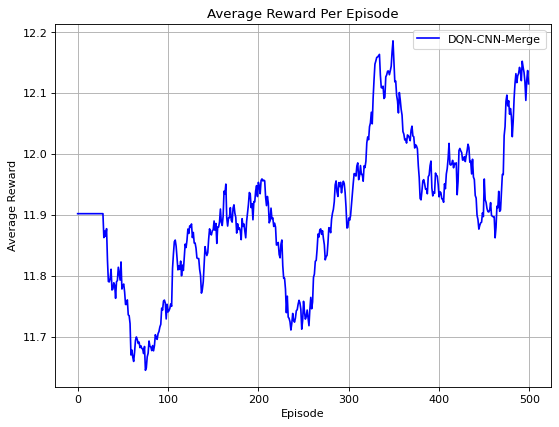

In [ ]:
plt.figure(figsize=(8,6),dpi=80)
plt.plot(rolling,c='b',label='DQN-CNN-Merge')
# plt.fill_between(np.arange(1,3+1,1), (rolling-confidence_interval),
#                  (rolling+confidence_interval), color='b', alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Average Reward Per Episode")
plt.legend()
plt.grid()
plt.show()

## **Test Agent and Record Video of Rendering**

--------------
Loading experience...
--------------
Episode:  0   | Total Reward: 11.3
Episode:  1   | Total Reward: 11.08
Episode:  2   | Total Reward: 10.97
Episode:  3   | Total Reward: 11.08
Episode:  4   | Total Reward: 11.08
Episode:  5   | Total Reward: 11.08
Episode:  6   | Total Reward: 10.75
Episode:  7   | Total Reward: 11.08
Episode:  8   | Total Reward: 11.75
Episode:  9   | Total Reward: 11.08
Episode:  10   | Total Reward: 11.08
Episode:  11   | Total Reward: 11.08
Episode:  12   | Total Reward: 11.05
Episode:  13   | Total Reward: 10.11
Episode:  14   | Total Reward: 11.08
Episode:  15   | Total Reward: 10.89
Episode:  16   | Total Reward: 11.08
Episode:  17   | Total Reward: 11.08
Episode:  18   | Total Reward: 11.67
Episode:  19   | Total Reward: 10.86
Episode:  20   | Total Reward: 11.08
Episode:  21   | Total Reward: 11.39
Episode:  22   | Total Reward: 11.08
Episode:  23   | Total Reward: 11.08
Episode:  24   | Total Reward: 11.08
Episode:  25   | Total Reward: 11.

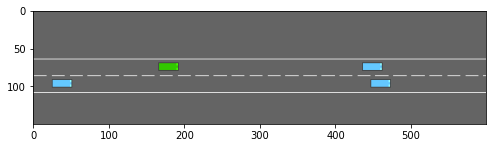

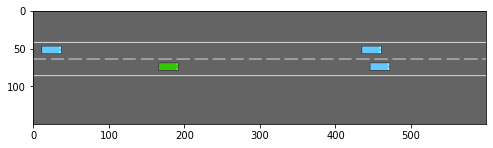

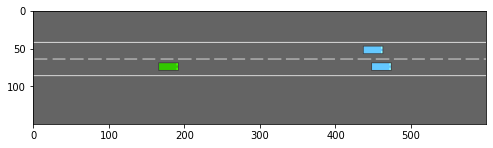

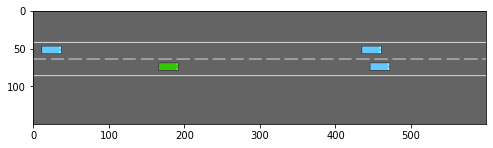

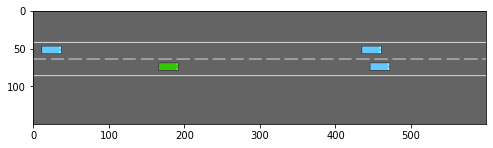

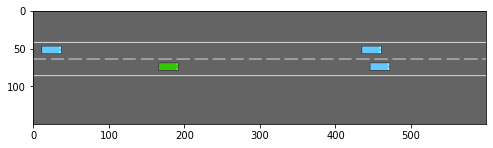

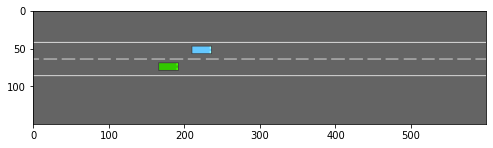

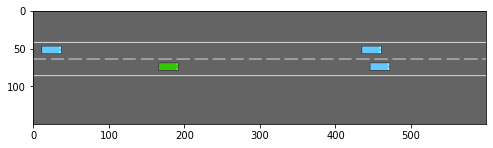

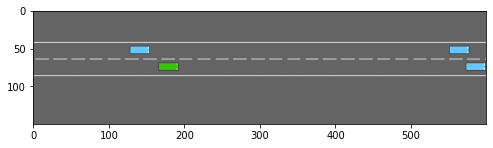

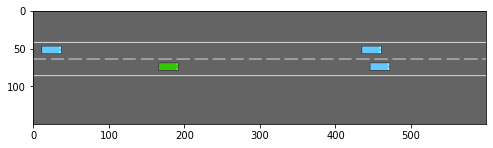

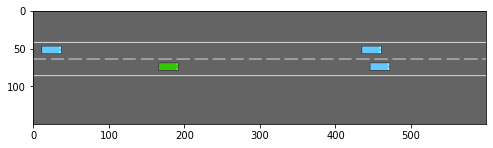

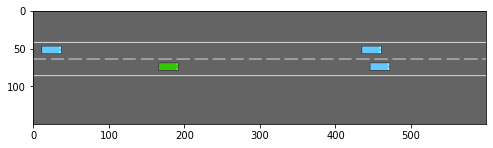

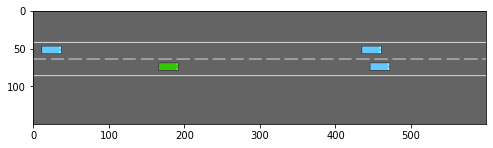

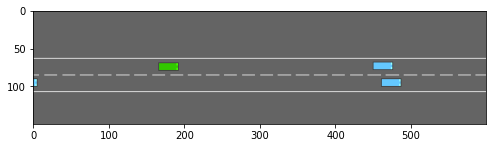

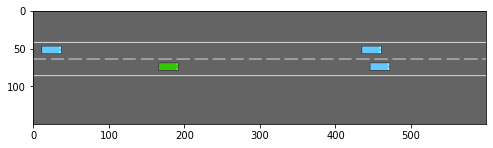

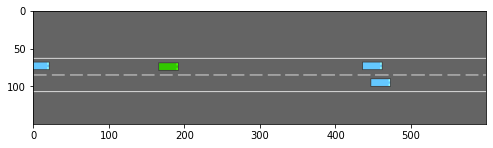

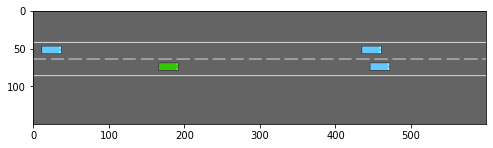

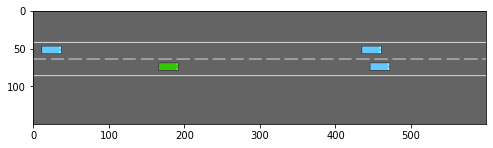

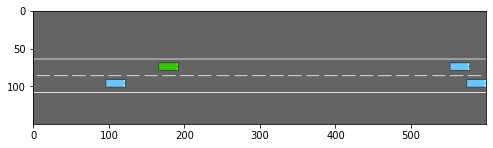

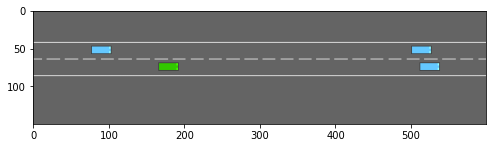

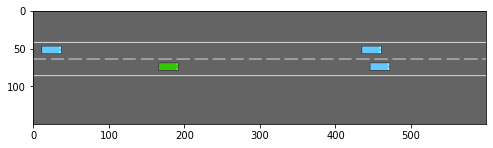

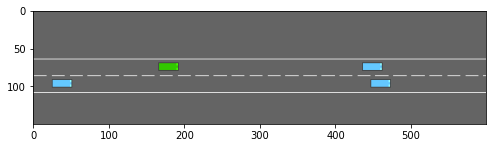

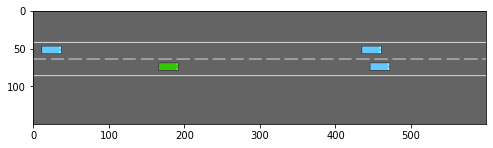

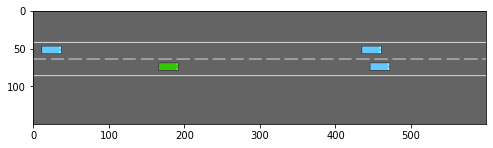

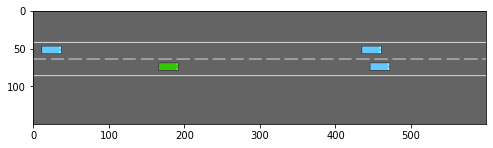

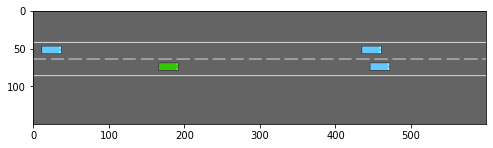

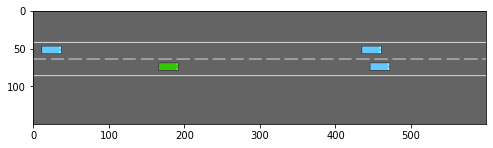

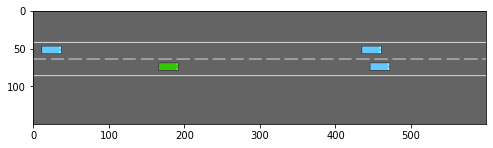

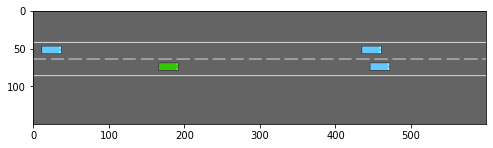

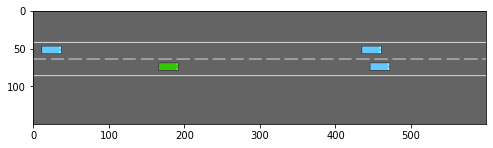

In [ ]:
test_agent_cnn("merge-v0","/content/drive/MyDrive/HW5/CNN/Weights/reward13weights.pt",
               Epsiode=30,save_path="/content/drive/MyDrive/HW5/CNN/Render/",
               file_name="Cnn.gif")